## Trackball Analysis
*Nhat Le, May 2018*

This is a file for analysis of the left/right trackball behavior and imaging data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.io
import pandas as pd


%matplotlib inline

In [34]:
# Load the data from the mat files
rawc_data = scipy.io.loadmat('raw_c.mat', squeeze_me=True)['raw_c']
rawi_data = scipy.io.loadmat('raw_i.mat', squeeze_me=True)['raw_i']
mean_velc_data = scipy.io.loadmat('mean_vel_c.mat', squeeze_me=True)['mean_vel_c']
mean_veli_data = scipy.io.loadmat('mean_vel_i.mat', squeeze_me=True)['mean_vel_i']
mvmt_startc_data = scipy.io.loadmat('mvmt_start_c.mat', squeeze_me=True)['mvmt_start_c']
mvmt_starti_data = scipy.io.loadmat('mvmt_start_i.mat', squeeze_me=True)['mvmt_start_i']
rtc_data = scipy.io.loadmat('rt_c.mat', squeeze_me=True)['rt_c']
rti_data = scipy.io.loadmat('rt_i.mat', squeeze_me=True)['rt_i']
trial_orderc_data = scipy.io.loadmat('trial_order_c.mat', squeeze_me=True)['trial_order_c']
trial_orderi_data = scipy.io.loadmat('trial_order_i.mat', squeeze_me=True)['trial_order_i']


ref_table = scipy.io.loadmat('ref_table.mat')['ref_table']
ref_frame = pd.DataFrame(ref_table, columns=['cellID', 'session', 'id_sess', 'SC', 'modulated', 'side'])

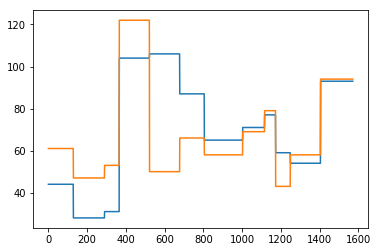

In [3]:
def get_ntrials(data):
    '''Given a raw data struct, return an array of the number 
    of trials that each cell was recorded'''
    ntrials = []
    for i in range(len(data)):
        ntrials.append(len(data[i]))
    return ntrials

ntrialsC = get_ntrials(mean_velc_data)
ntrialsI = get_ntrials(mean_veli_data)

# Maximum number of trials for each cell
ntrials_max = np.max(ntrialsC + ntrialsI)

# Number of cells
ncells = len(ntrialsC)

plt.plot(ntrialsC)
plt.plot(ntrialsI)

### Tidy data
Make a tidy data frame that contains all the information

In [19]:
def make_tidy_frame(raw_struct, contra, varname):
    '''Inputs: raw_struct, the raw data array
    contra: 1 if contra, 0 if ipsi
    ncells: number of cells
    ntrials_max: max number of trials
    Returns a tidy data frame with columns: cells, trials, varname and contra'''
    # Gather relevant parameters
    ntrials = get_ntrials(raw_struct)
    ntrials_max = max(ntrials)
    ncells = len(ntrials)
    
    # Make an array with first column being number of cells,
    # Each row is a nan-padded array representing the value of the parameter
    # of each cell
    cell_arr = np.empty((ncells, ntrials_max + 1))
    cell_arr[:] = np.nan

    for i in range(ncells):
        cell_arr[i, 1:ntrials[i] + 1] = raw_struct[i]
        cell_arr[i, 0] = i
        
    # Make the tidy frame
    cell_frame = pd.DataFrame(cell_arr)
    cell_frame = pd.melt(cell_frame, id_vars=[0], var_name='trial', value_name=varname)
    cell_frame.columns = ['cellID', 'trial', varname]
    cell_frame = cell_frame.dropna()
    cell_frame['contra'] = contra
    cell_frame.trial = cell_frame.trial - 1
    
    return cell_frame

In [20]:
mean_velC_fr = make_tidy_frame(mean_velc_data, 1, 'mean_vel')
mean_velI_fr = make_tidy_frame(mean_veli_data, 0, 'mean_vel')

mvmt_startC_fr = make_tidy_frame(mvmt_startc_data, 1, 'mvmt_start')
mvmt_startI_fr = make_tidy_frame(mvmt_starti_data, 0, 'mvmt_start')

rtC_fr = make_tidy_frame(rtc_data, 1, 'rt')
rtI_fr = make_tidy_frame(rti_data, 0, 'rt')

trial_orderC_fr = make_tidy_frame(trial_orderc_data, 1, 'trial_order')
trial_orderI_fr = make_tidy_frame(trial_orderi_data, 0, 'trial_order')

In [21]:
# Merge all data frames
Cframe = pd.merge(rtC_fr, mvmt_startC_fr, on=['cellID', 'trial', 'contra'])
Cframe = pd.merge(Cframe, mean_velC_fr, on=['cellID', 'trial', 'contra'])
Cframe = pd.merge(Cframe, trial_orderC_fr, on=['cellID', 'trial', 'contra'])

Iframe = pd.merge(rtI_fr, mvmt_startI_fr, on=['cellID', 'trial', 'contra'])
Iframe = pd.merge(Iframe, mean_velI_fr, on=['cellID', 'trial', 'contra'])
Iframe = pd.merge(Iframe, trial_orderI_fr, on=['cellID', 'trial', 'contra'])

# Now merge all into a master frame
CIframe = pd.concat([Cframe, Iframe])
all_frame = CIframe.merge(ref_frame, on='cellID')

In [23]:
# Just a check that everything is consistent
print('contra frames shapes')
print(trial_orderC_fr.shape)
print(mean_velC_fr.shape)
print(mvmt_startC_fr.shape)
print(rtC_fr.shape)
print(Cframe.shape)

print('ipsi frames shapes')
print(trial_orderI_fr.shape)
print(mean_velI_fr.shape)
print(mvmt_startI_fr.shape)
print(rtI_fr.shape)
print(Iframe.shape)

contra frames shapes
(110070, 4)
(110070, 4)
(110070, 4)
(110070, 4)
(110070, 7)
ipsi frames shapes
(106476, 4)
(106476, 4)
(106476, 4)
(106476, 4)
(106476, 7)


## Data analysis

In [11]:
np.min(trial_orderi[0])

NameError: name 'trial_orderi' is not defined

In [ ]:
plt.hist(mvmt_startc[900])
# The two bumps are suggestive of two different modes of operation - 
# TODO: take a look at 
# the neural signatures of those two modes

In [ ]:
mean_velc_data[0].shape
mean_veli_data[0].shape


In [ ]:
ref_frame

In [ ]:
x = np.arange(10)
x[2:5]

In [ ]:
# Find z-score
cell_data = rawc_data[900]
#plt.plot(cell_data);

baseline_start = 5
baseline_end = 15

baseline_activity = cell_data[baseline_start:baseline_end]

# Find mean and std baseline
baseline_mean = np.mean(baseline_activity, axis=0)
baseline_sd = np.std(baseline_activity, axis=0)

# Normalize
cell_data_normed = (cell_data - baseline_mean) / baseline_sd
mean_cell_data = np.mean(cell_data_normed, axis=1)


plt.plot(cell_data_normed, 'b', alpha=0.1);
plt.plot(mean_cell_data)
plt.vlines(14.5, -10, 10, linestyles='dotted')

In [ ]:
cell_data.shape

In [ ]:
a = (cell_data - baseline_mean) / baseline_sd


In [ ]:
plt.plot(a);

In [ ]:
cell_data

In [ ]:
cell_num = 1400
mean_cell = np.mean(rawc_data[cell_num], axis=1)

plt.plot(rawc_data[cell_num], 'b', alpha=0.1);
plt.plot(mean_cell)

In [ ]:
means = np.zeros((1572, 31))

for i in range(1572):
    celldata = rawc_data[i]
    means[i,:] = np.mean(celldata, axis=1)

In [ ]:
plt.figure(figsize=(15,50))
plt.imshow(means)

In [ ]:
# Modulated cells are all SC
ref_pd.groupby('modulated')['SC'].mean()

In [ ]:
ref_pd[ref_pd.session == 1]

In [ ]:
# Group by SC
ref_pd.groupby('SC')['modulated'].mean()

In [ ]:
ref_pd.groupby('SC')['side'].mean()

## Correlation between cell activity and mean velocity

In [ ]:
# TODO: look at correlation between velocity and cell activity
ncell = 20
cell_data = rawc_data[ncell]
mean_cell_activity = np.mean(cell_data, axis=0)
plt.scatter(mean_cell_activity, mean_velc_data[ncell])